# Баланс классов

Прежде всего надо убедиться что датасет сбалансирован:

Посмотрим на распределение элементов разных класов по батчам.

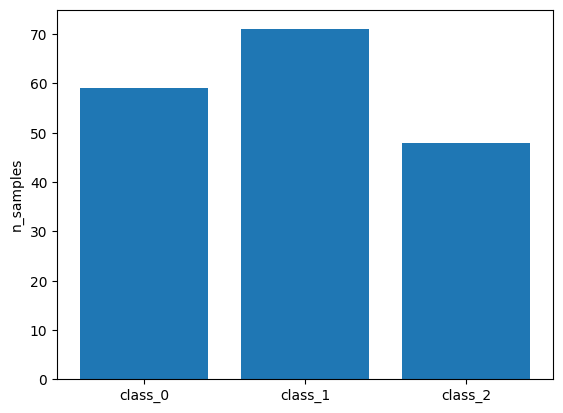

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine


def show_class_balance(y,classes):
  _, counts = torch.unique(torch.tensor(y),return_counts = True)
  plt.bar(classes,counts)
  plt.ylabel('n_samples')
  plt.ylim([0, 75])
  plt.show()

wine = load_wine()
classes = wine.target_names

show_class_balance(wine.target,classes)

Разница в 10-20% будет незначительна, поэтому для наглядности мы искусственно разбалансируем наш датасет при помощи метода [make_imbalance](https://imbalanced-learn.org/stable/references/generated/imblearn.datasets.make_imbalance.html)

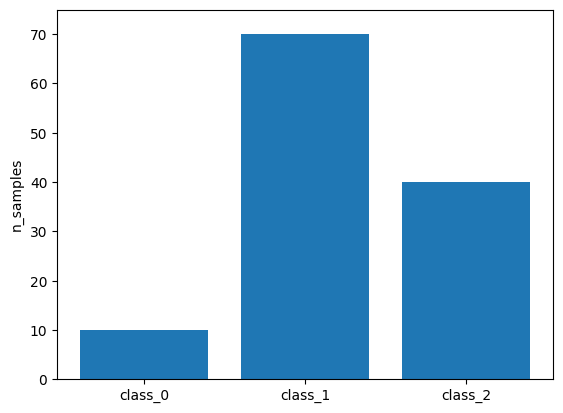

In [ ]:
from imblearn.datasets import make_imbalance

X,y = make_imbalance(wine.data,wine.target,sampling_strategy={0: 10, 1: 70, 2: 40},random_state=42)
show_class_balance(y,classes)

### Балансирование представленности объектов в батчах

В случае нейросетей можно балансировать встречаемость каждого класса не на уровне датасета, а на уровне батча. Например, собираем каждый батч таким образом, чтобы в нем было поровну всех классов.

 Это может улучшать сходимость даже в случае небольшого дисбаланса или его отсутствия, т.к. мы будем избегать шагов обучения нейросети, в которых она просто не увидела какого-то класса в силу случайных причин.




<img src="https://ml.gan4x4.ru/msu/dev-1.9/L11/out/batch_balancing.png" >


В Pytorch эту функциональность можно получить используя класс [WeightedRandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler) . Для его инициализации требуется рассчитать вес каждого класса. Сумма весов не обязана быть равна единице.

In [ ]:
import torch
# https://pytorch.org/docs/stable/generated/torch.unique.html
_, counts = torch.unique(torch.tensor(y),return_counts = True)
weights = counts.max() / counts
print('Classes: ', classes)
print('Weights: ', weights)

Classes:  ['class_0' 'class_1' 'class_2']
Weights:  tensor([7.0000, 1.0000, 1.7500])


Теперь создаем объект [WeightedRandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler) в конструктор подаем два аргумента:

- список весов для **каждого** элемента в датасете
- количество элементов (можно использовать не весь датасет)

In [ ]:
from torch.utils.data import DataLoader,  TensorDataset, WeightedRandomSampler

tensor_x = torch.Tensor(X) # transform to torch tensor
tensor_y = torch.Tensor(y)
dataset = TensorDataset(tensor_x,tensor_y)

batch_size = 8

weight_for_sample = [] # Every sample must have a weight
for l in y:
  weight_for_sample.append(weights[l].item())

sampler = WeightedRandomSampler(torch.tensor(weight_for_sample),len(dataset))
loader = DataLoader(dataset, batch_size=32, drop_last=True, sampler=sampler)

Labels: [1, 1, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 2, 1, 1, 1, 0, 0, 1, 0, 2, 2, 1, 0, 2, 0, 2, 2, 2] Classes in batch: [13, 10, 9]
Labels: [2, 2, 1, 2, 0, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0] Classes in batch: [9, 9, 14]
Labels: [2, 0, 0, 2, 1, 2, 0, 0, 2, 1, 2, 2, 2, 0, 2, 0, 2, 1, 1, 0, 1, 2, 0, 1, 1, 2, 0, 1, 0, 0, 0, 1] Classes in batch: [12, 9, 11]


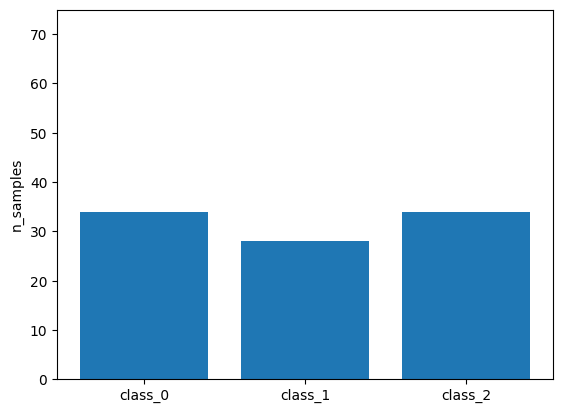

In [ ]:
batch_labels = []
for data, labels in loader:
  print("Labels:",labels.int().tolist(), "Classes in batch:",torch.unique(labels,return_counts = True)[1].tolist())
  batch_labels.append(labels.tolist())

show_class_balance(batch_labels,classes)

Результаты будут отличаться от запуска к запуску. Но видно что в батчах объекты каждого класса встречаются почти равномерно.